# Deep Learning Models and Combination Models

In this notebook we develop our final series of models for each of our stock data. Our primary focus will be LSTM models. We will model the stock prices with and without our exogenous variables and compare our performance metrics.

In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, max_error

import random

In [3]:
processed_data = pd.read_csv("C:/Users/benns/Projects/Forecasting- Local vs. Base/formatted_data.csv", index_col = 'Date')
processed_data.head()

,PNC,PPG,EQT,Unemployment,Med Home
Date,,,,,
2000-02-01,-3.769677,-13.250999,-2.002493,0.000000,-0.627032
2000-03-01,-2.206935,-4.695125,17.302942,-7.843137,0.064328
2000-04-01,11.113336,8.827048,11.776062,-19.148936,0.940838
2000-05-01,-0.533925,1.906303,7.032762,13.157895,1.327662
2000-06-01,16.687651,-14.631165,2.186279,6.976744,1.124730


In [18]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### LSTM

In [74]:
set_seed(42)


target = "PNC"   
n_forecast = 12  
lags = [1, 2, 12]

series = processed_data[target].astype(float)
series.index = pd.to_datetime(series.index) 


train = series.iloc[:-n_forecast]
test = series.iloc[-n_forecast:]


def create_lagged_features(series, lags):
    df = pd.DataFrame({"y": series})
    for lag in lags:
        df[f"lag_{lag}"] = series.shift(lag)
    df = df.dropna()
    X = df.drop("y", axis=1).values
    y = df["y"].values
    return X, y, df.index

X, y, idx = create_lagged_features(series, lags)


train_size = len(train) - max(lags)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (samples, seq_len=1, features)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1,
                 dropout_lstm=0.3, dropout_dense=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_lstm)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout_dense = nn.Dropout(dropout_dense)
        self.fc_out = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout_dense(out)
        out = self.fc_out(out)
        return out


model = LSTMModel(input_size=len(lags), hidden_size=15,
                  num_layers=2, dropout_lstm=0.1, dropout_dense=0.00)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)  # L2 regularization


epochs = 500
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


model.eval()
preds = []
current_series = series.copy()

for i in range(n_forecast):
    lag_values = [current_series.iloc[-lag] for lag in lags]
    X_input = torch.tensor(lag_values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        y_pred = model(X_input).item()
    preds.append(y_pred)
    current_series = pd.concat([
        current_series,
        pd.Series([y_pred], index=[series.index[-1] + pd.DateOffset(months=i+1)])
    ])


Epoch 10/500, Loss: 51.9264
Epoch 20/500, Loss: 43.3081
Epoch 30/500, Loss: 42.4003
Epoch 40/500, Loss: 39.8652
Epoch 50/500, Loss: 36.6093
Epoch 60/500, Loss: 34.9547
Epoch 70/500, Loss: 34.5402
Epoch 80/500, Loss: 31.0278
Epoch 90/500, Loss: 29.0666
Epoch 100/500, Loss: 23.6138
Epoch 110/500, Loss: 30.3217
Epoch 120/500, Loss: 29.3105
Epoch 130/500, Loss: 29.8347
Epoch 140/500, Loss: 27.8318
Epoch 150/500, Loss: 29.2467
Epoch 160/500, Loss: 17.8984
Epoch 170/500, Loss: 18.2451
Epoch 180/500, Loss: 26.1937
Epoch 190/500, Loss: 19.8004
Epoch 200/500, Loss: 22.4301
Epoch 210/500, Loss: 16.4171
Epoch 220/500, Loss: 22.0243
Epoch 230/500, Loss: 15.5408
Epoch 240/500, Loss: 10.3626
Epoch 250/500, Loss: 15.3825
Epoch 260/500, Loss: 13.0133
Epoch 270/500, Loss: 14.0600
Epoch 280/500, Loss: 20.2660
Epoch 290/500, Loss: 12.6444
Epoch 300/500, Loss: 9.5223
Epoch 310/500, Loss: 15.6861
Epoch 320/500, Loss: 22.1856
Epoch 330/500, Loss: 13.7626
Epoch 340/500, Loss: 26.0030
Epoch 350/500, Loss: 16.

In [77]:
rmse = np.sqrt(mean_squared_error(preds, y_test))
mae = max_error(preds, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {mae:.4f}")

pnc_lstm1_preds = preds

RMSE: 5.7627
Max Error: 9.5701


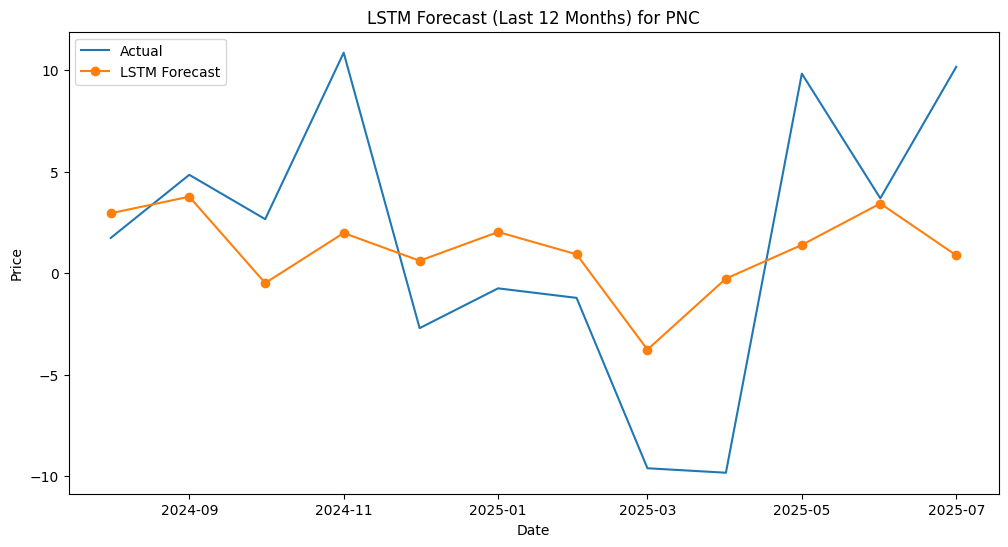

In [78]:
# ------------------------------
# Plot results
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, preds, label="LSTM Forecast", marker="o")
plt.title(f"LSTM Forecast (Last {n_forecast} Months) for {target}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [95]:
set_seed(42)


target = "PPG"   
n_forecast = 12  
lags = [1, 2, 12]

series = processed_data[target].astype(float)
series.index = pd.to_datetime(series.index) 


train = series.iloc[:-n_forecast]
test = series.iloc[-n_forecast:]


def create_lagged_features(series, lags):
    df = pd.DataFrame({"y": series})
    for lag in lags:
        df[f"lag_{lag}"] = series.shift(lag)
    df = df.dropna()
    X = df.drop("y", axis=1).values
    y = df["y"].values
    return X, y, df.index

X, y, idx = create_lagged_features(series, lags)


train_size = len(train) - max(lags)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (samples, seq_len=1, features)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1,
                 dropout_lstm=0.3, dropout_dense=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_lstm)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout_dense = nn.Dropout(dropout_dense)
        self.fc_out = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout_dense(out)
        out = self.fc_out(out)
        return out


model = LSTMModel(input_size=len(lags), hidden_size=20,
                  num_layers=2, dropout_lstm=0.2, dropout_dense=0.1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-1)  # L2 regularization


epochs = 500
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


model.eval()
preds = []
current_series = series.copy()

for i in range(n_forecast):
    lag_values = [current_series.iloc[-lag] for lag in lags]
    X_input = torch.tensor(lag_values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        y_pred = model(X_input).item()
    preds.append(y_pred)
    current_series = pd.concat([
        current_series,
        pd.Series([y_pred], index=[series.index[-1] + pd.DateOffset(months=i+1)])
    ])


Epoch 10/500, Loss: 19.5281
Epoch 20/500, Loss: 16.1021
Epoch 30/500, Loss: 18.4792
Epoch 40/500, Loss: 20.9902
Epoch 50/500, Loss: 22.1369
Epoch 60/500, Loss: 19.2806
Epoch 70/500, Loss: 18.8965
Epoch 80/500, Loss: 16.4401
Epoch 90/500, Loss: 19.5097
Epoch 100/500, Loss: 19.1465
Epoch 110/500, Loss: 20.3851
Epoch 120/500, Loss: 22.3431
Epoch 130/500, Loss: 16.3984
Epoch 140/500, Loss: 20.9783
Epoch 150/500, Loss: 17.7903
Epoch 160/500, Loss: 20.9010
Epoch 170/500, Loss: 21.5031
Epoch 180/500, Loss: 19.5242
Epoch 190/500, Loss: 17.3054
Epoch 200/500, Loss: 14.9824
Epoch 210/500, Loss: 18.9796
Epoch 220/500, Loss: 17.6234
Epoch 230/500, Loss: 19.2474
Epoch 240/500, Loss: 20.1631
Epoch 250/500, Loss: 16.2822
Epoch 260/500, Loss: 18.0880
Epoch 270/500, Loss: 21.2841
Epoch 280/500, Loss: 18.6766
Epoch 290/500, Loss: 18.7632
Epoch 300/500, Loss: 19.9732
Epoch 310/500, Loss: 15.9344
Epoch 320/500, Loss: 19.1549
Epoch 330/500, Loss: 17.3552
Epoch 340/500, Loss: 18.6669
Epoch 350/500, Loss: 19

In [96]:
rmse = np.sqrt(mean_squared_error(preds, y_test))
mae = max_error(preds, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {mae:.4f}")

ppg_lstm1_preds = preds

RMSE: 4.2794
Max Error: 10.0447


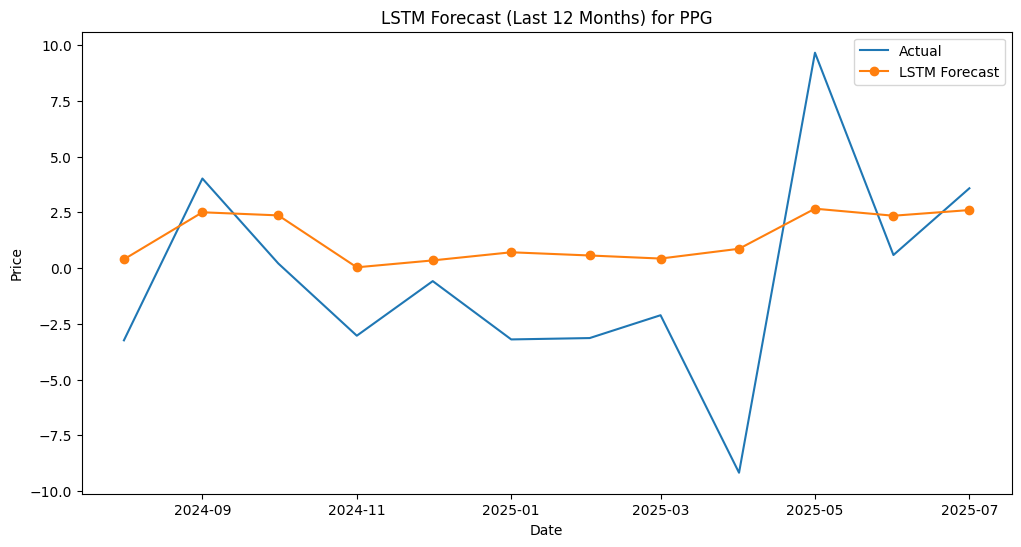

In [97]:
# ------------------------------
# Plot results
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, preds, label="LSTM Forecast", marker="o")
plt.title(f"LSTM Forecast (Last {n_forecast} Months) for {target}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [101]:
set_seed(42)


target = "EQT"   
n_forecast = 12  
lags = [1, 2, 12]

series = processed_data[target].astype(float)
series.index = pd.to_datetime(series.index) 


train = series.iloc[:-n_forecast]
test = series.iloc[-n_forecast:]


def create_lagged_features(series, lags):
    df = pd.DataFrame({"y": series})
    for lag in lags:
        df[f"lag_{lag}"] = series.shift(lag)
    df = df.dropna()
    X = df.drop("y", axis=1).values
    y = df["y"].values
    return X, y, df.index

X, y, idx = create_lagged_features(series, lags)


train_size = len(train) - max(lags)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (samples, seq_len=1, features)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1,
                 dropout_lstm=0.3, dropout_dense=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_lstm)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout_dense = nn.Dropout(dropout_dense)
        self.fc_out = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout_dense(out)
        out = self.fc_out(out)
        return out


model = LSTMModel(input_size=len(lags), hidden_size=20,
                  num_layers=2, dropout_lstm=0.2, dropout_dense=0.1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)  # L2 regularization


epochs = 500
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


model.eval()
preds = []
current_series = series.copy()

for i in range(n_forecast):
    lag_values = [current_series.iloc[-lag] for lag in lags]
    X_input = torch.tensor(lag_values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        y_pred = model(X_input).item()
    preds.append(y_pred)
    current_series = pd.concat([
        current_series,
        pd.Series([y_pred], index=[series.index[-1] + pd.DateOffset(months=i+1)])
    ])


Epoch 10/500, Loss: 29.2673
Epoch 20/500, Loss: 36.6025
Epoch 30/500, Loss: 33.8124
Epoch 40/500, Loss: 25.6882
Epoch 50/500, Loss: 23.2859
Epoch 60/500, Loss: 20.5698
Epoch 70/500, Loss: 25.9186
Epoch 80/500, Loss: 21.9546
Epoch 90/500, Loss: 31.0908
Epoch 100/500, Loss: 10.7690
Epoch 110/500, Loss: 17.3028
Epoch 120/500, Loss: 24.0699
Epoch 130/500, Loss: 20.8266
Epoch 140/500, Loss: 20.8079
Epoch 150/500, Loss: 16.2545
Epoch 160/500, Loss: 16.7161
Epoch 170/500, Loss: 17.5009
Epoch 180/500, Loss: 19.3772
Epoch 190/500, Loss: 17.5859
Epoch 200/500, Loss: 25.9701
Epoch 210/500, Loss: 25.7141
Epoch 220/500, Loss: 24.3664
Epoch 230/500, Loss: 20.8871
Epoch 240/500, Loss: 19.7938
Epoch 250/500, Loss: 32.5101
Epoch 260/500, Loss: 21.7790
Epoch 270/500, Loss: 32.7010
Epoch 280/500, Loss: 26.4111
Epoch 290/500, Loss: 32.7951
Epoch 300/500, Loss: 26.3562
Epoch 310/500, Loss: 27.9307
Epoch 320/500, Loss: 27.5165
Epoch 330/500, Loss: 25.0463
Epoch 340/500, Loss: 34.6941
Epoch 350/500, Loss: 19

In [102]:
rmse = np.sqrt(mean_squared_error(preds, y_test))
mae = max_error(preds, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {mae:.4f}")

eqt_lstm1_preds = preds

RMSE: 6.6195
Max Error: 12.8124


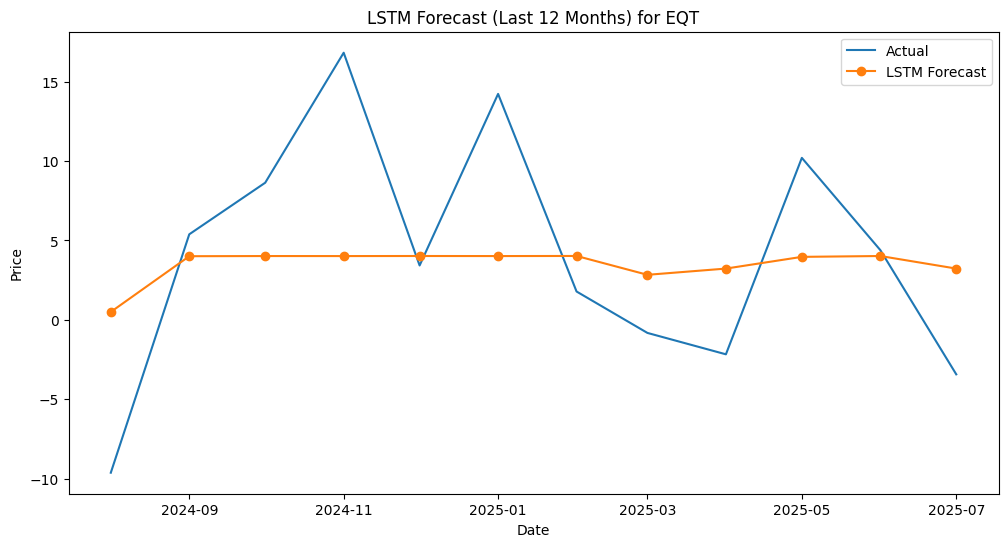

In [103]:
# ------------------------------
# Plot results
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, preds, label="LSTM Forecast", marker="o")
plt.title(f"LSTM Forecast (Last {n_forecast} Months) for {target}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Each of our LSTM models outperformed both the SARIMAX and Tree based models after some hyper parameter tuning. Like the tree models, these models preferred lower parameter values like a low number of hidden units and a higher dropout rate. I suspect that with such a small dataset this class of models is prove to overfitting the training data, so that a lower complexity threshold and higher dropout rate reduces these issues.

### LSTM with Exogenous Data

In [114]:
target = "PNC"   
exog_vars = ["Unemployment", "Med Home"]
n_forecast = 12  
lags = [1, 2, 12]


set_seed(42)


series = processed_data[target].astype(float)
series.index = pd.to_datetime(series.index)

exog = processed_data[exog_vars].astype(float)
exog.index = pd.to_datetime(exog.index)


train = series.iloc[:-n_forecast]
test = series.iloc[-n_forecast:]
train_exog = exog.iloc[:-n_forecast]
test_exog = exog.iloc[-n_forecast:]


def create_lagged_features(series, exog, lags):
    df = pd.DataFrame({"y": series})
    for lag in lags:
        df[f"{target}_lag_{lag}"] = series.shift(lag)
        for var in exog.columns:
            df[f"{var}_lag_{lag}"] = exog[var].shift(lag)
    df = df.dropna()
    X = df.drop("y", axis=1).values
    y = df["y"].values
    return X, y, df.index

X, y, idx = create_lagged_features(series, exog, lags)


train_size = len(train) - max(lags)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2, dense_dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dense_dropout)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
model = LSTMModel(input_size=input_size, hidden_size=20, num_layers=2, dropout=0.005, dense_dropout=0.0)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0)


epochs = 500
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


model.eval()
preds = []
current_series = series.copy()
current_exog = exog.copy()

for i in range(n_forecast):
    
    lag_features = {}
    for lag in lags:
        lag_features[f"{target}_lag_{lag}"] = current_series.iloc[-lag]
        for var in exog_vars:
            lag_features[f"{var}_lag_{lag}"] = current_exog[var].iloc[-lag]

    X_input = torch.tensor(list(lag_features.values()), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        y_pred = model(X_input).item()
    preds.append(y_pred)

    
    next_index = current_series.index[-1] + pd.DateOffset(months=1)
    current_series = pd.concat([current_series, pd.Series([y_pred], index=[next_index])])


Epoch 10/500, Loss: 16.2082
Epoch 20/500, Loss: 27.6331
Epoch 30/500, Loss: 5.1841
Epoch 40/500, Loss: 6.8937
Epoch 50/500, Loss: 3.0505
Epoch 60/500, Loss: 2.9349
Epoch 70/500, Loss: 5.6195
Epoch 80/500, Loss: 3.2111
Epoch 90/500, Loss: 4.6705
Epoch 100/500, Loss: 4.3808
Epoch 110/500, Loss: 3.0193
Epoch 120/500, Loss: 2.6114
Epoch 130/500, Loss: 1.5170
Epoch 140/500, Loss: 1.7899
Epoch 150/500, Loss: 1.0182
Epoch 160/500, Loss: 4.7977
Epoch 170/500, Loss: 3.1736
Epoch 180/500, Loss: 1.8857
Epoch 190/500, Loss: 4.0184
Epoch 200/500, Loss: 9.2595
Epoch 210/500, Loss: 5.9652
Epoch 220/500, Loss: 3.6206
Epoch 230/500, Loss: 1.3440
Epoch 240/500, Loss: 4.6657
Epoch 250/500, Loss: 5.7094
Epoch 260/500, Loss: 9.6315
Epoch 270/500, Loss: 11.5412
Epoch 280/500, Loss: 5.5476
Epoch 290/500, Loss: 4.0667
Epoch 300/500, Loss: 2.1619
Epoch 310/500, Loss: 0.8386
Epoch 320/500, Loss: 2.6777
Epoch 330/500, Loss: 1.7586
Epoch 340/500, Loss: 7.4620
Epoch 350/500, Loss: 11.7989
Epoch 360/500, Loss: 14.7

In [115]:
rmse = np.sqrt(mean_squared_error(preds, y_test))
mae = max_error(preds, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {mae:.4f}")

pnc_lstm2_preds = preds

RMSE: 5.2856
Max Error: 9.7363


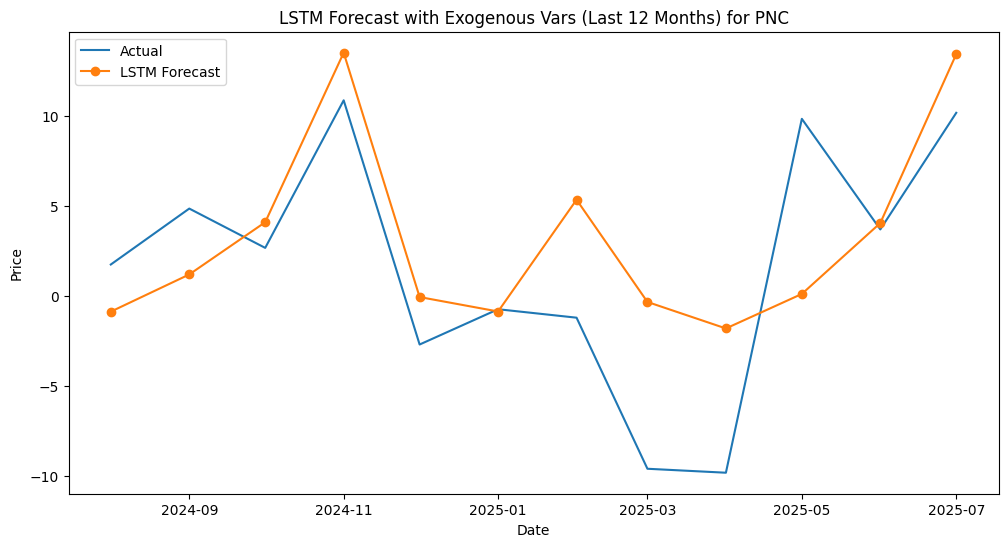

In [116]:
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, preds, label="LSTM Forecast", marker="o")
plt.title(f"LSTM Forecast with Exogenous Vars (Last {n_forecast} Months) for {target}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [162]:
target = "PPG"   
exog_vars = ["Unemployment", "Med Home"]
n_forecast = 12  
lags = [1, 2, 12]


set_seed(42)


series = processed_data[target].astype(float)
series.index = pd.to_datetime(series.index)

exog = processed_data[exog_vars].astype(float)
exog.index = pd.to_datetime(exog.index)


train = series.iloc[:-n_forecast]
test = series.iloc[-n_forecast:]
train_exog = exog.iloc[:-n_forecast]
test_exog = exog.iloc[-n_forecast:]


def create_lagged_features(series, exog, lags):
    df = pd.DataFrame({"y": series})
    for lag in lags:
        df[f"{target}_lag_{lag}"] = series.shift(lag)
        for var in exog.columns:
            df[f"{var}_lag_{lag}"] = exog[var].shift(lag)
    df = df.dropna()
    X = df.drop("y", axis=1).values
    y = df["y"].values
    return X, y, df.index

X, y, idx = create_lagged_features(series, exog, lags)


train_size = len(train) - max(lags)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2, dense_dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dense_dropout)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
model = LSTMModel(input_size=input_size, hidden_size=60, num_layers=3, dropout=0.2, dense_dropout=0.1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0)


epochs = 500
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


model.eval()
preds = []
current_series = series.copy()
current_exog = exog.copy()

for i in range(n_forecast):
    
    lag_features = {}
    for lag in lags:
        lag_features[f"{target}_lag_{lag}"] = current_series.iloc[-lag]
        for var in exog_vars:
            lag_features[f"{var}_lag_{lag}"] = current_exog[var].iloc[-lag]

    X_input = torch.tensor(list(lag_features.values()), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        y_pred = model(X_input).item()
    preds.append(y_pred)

    
    next_index = current_series.index[-1] + pd.DateOffset(months=1)
    current_series = pd.concat([current_series, pd.Series([y_pred], index=[next_index])])

Epoch 10/500, Loss: 19.2240
Epoch 20/500, Loss: 20.3458
Epoch 30/500, Loss: 19.3904
Epoch 40/500, Loss: 21.1189
Epoch 50/500, Loss: 7.6770
Epoch 60/500, Loss: 33.7820
Epoch 70/500, Loss: 14.7475
Epoch 80/500, Loss: 16.9010
Epoch 90/500, Loss: 19.0608
Epoch 100/500, Loss: 15.0538
Epoch 110/500, Loss: 16.5194
Epoch 120/500, Loss: 8.1953
Epoch 130/500, Loss: 11.2799
Epoch 140/500, Loss: 11.1925
Epoch 150/500, Loss: 9.2307
Epoch 160/500, Loss: 10.4048
Epoch 170/500, Loss: 14.7946
Epoch 180/500, Loss: 15.9934
Epoch 190/500, Loss: 22.5331
Epoch 200/500, Loss: 17.8634
Epoch 210/500, Loss: 16.5822
Epoch 220/500, Loss: 15.0459
Epoch 230/500, Loss: 8.5757
Epoch 240/500, Loss: 6.4279
Epoch 250/500, Loss: 10.8149
Epoch 260/500, Loss: 26.8295
Epoch 270/500, Loss: 18.8875
Epoch 280/500, Loss: 15.3318
Epoch 290/500, Loss: 20.0186
Epoch 300/500, Loss: 15.2624
Epoch 310/500, Loss: 22.0901
Epoch 320/500, Loss: 18.1640
Epoch 330/500, Loss: 15.8875
Epoch 340/500, Loss: 16.0066
Epoch 350/500, Loss: 15.3932

In [163]:
rmse = np.sqrt(mean_squared_error(preds, y_test))
mae = max_error(preds, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {mae:.4f}")

ppp_lstm2_preds = preds

RMSE: 4.3353
Max Error: 9.1738


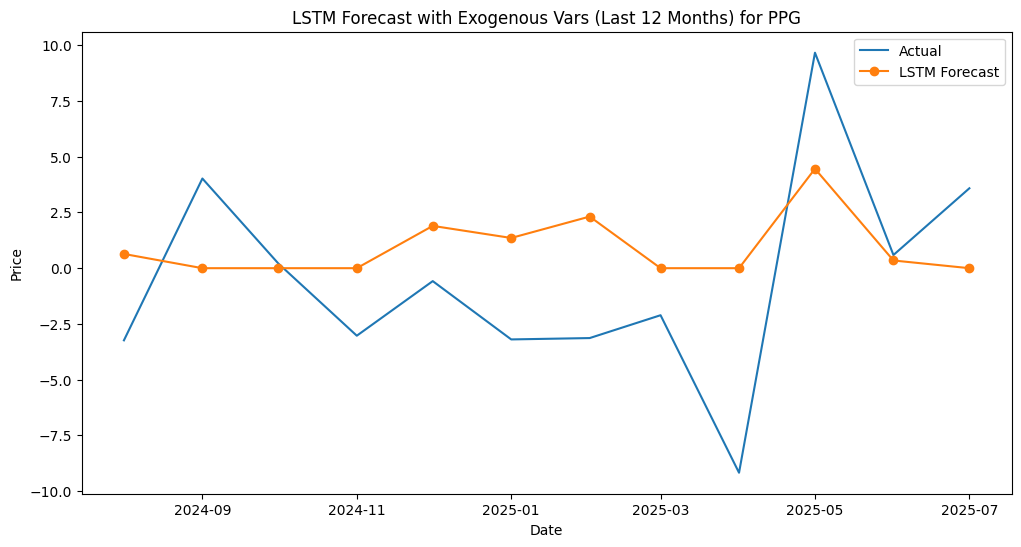

In [164]:
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, preds, label="LSTM Forecast", marker="o")
plt.title(f"LSTM Forecast with Exogenous Vars (Last {n_forecast} Months) for {target}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [168]:
target = "EQT"   
exog_vars = ["Unemployment", "Med Home"]
n_forecast = 12  
lags = [1, 2, 12]


set_seed(42)


series = processed_data[target].astype(float)
series.index = pd.to_datetime(series.index)

exog = processed_data[exog_vars].astype(float)
exog.index = pd.to_datetime(exog.index)


train = series.iloc[:-n_forecast]
test = series.iloc[-n_forecast:]
train_exog = exog.iloc[:-n_forecast]
test_exog = exog.iloc[-n_forecast:]


def create_lagged_features(series, exog, lags):
    df = pd.DataFrame({"y": series})
    for lag in lags:
        df[f"{target}_lag_{lag}"] = series.shift(lag)
        for var in exog.columns:
            df[f"{var}_lag_{lag}"] = exog[var].shift(lag)
    df = df.dropna()
    X = df.drop("y", axis=1).values
    y = df["y"].values
    return X, y, df.index

X, y, idx = create_lagged_features(series, exog, lags)


train_size = len(train) - max(lags)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2, dense_dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dense_dropout)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
model = LSTMModel(input_size=input_size, hidden_size=60, num_layers=2, dropout=0.2, dense_dropout=0.1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0)


epochs = 500
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


model.eval()
preds = []
current_series = series.copy()
current_exog = exog.copy()

for i in range(n_forecast):
    
    lag_features = {}
    for lag in lags:
        lag_features[f"{target}_lag_{lag}"] = current_series.iloc[-lag]
        for var in exog_vars:
            lag_features[f"{var}_lag_{lag}"] = current_exog[var].iloc[-lag]

    X_input = torch.tensor(list(lag_features.values()), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        y_pred = model(X_input).item()
    preds.append(y_pred)

    
    next_index = current_series.index[-1] + pd.DateOffset(months=1)
    current_series = pd.concat([current_series, pd.Series([y_pred], index=[next_index])])

Epoch 10/500, Loss: 19.1088
Epoch 20/500, Loss: 14.7451
Epoch 30/500, Loss: 26.6053
Epoch 40/500, Loss: 23.8123
Epoch 50/500, Loss: 41.3239
Epoch 60/500, Loss: 35.1972
Epoch 70/500, Loss: 33.4891
Epoch 80/500, Loss: 37.8823
Epoch 90/500, Loss: 74.6424
Epoch 100/500, Loss: 28.9714
Epoch 110/500, Loss: 26.8333
Epoch 120/500, Loss: 27.1958
Epoch 130/500, Loss: 22.8510
Epoch 140/500, Loss: 29.5810
Epoch 150/500, Loss: 27.1462
Epoch 160/500, Loss: 14.7505
Epoch 170/500, Loss: 10.0759
Epoch 180/500, Loss: 16.3343
Epoch 190/500, Loss: 16.8379
Epoch 200/500, Loss: 13.9813
Epoch 210/500, Loss: 19.8617
Epoch 220/500, Loss: 25.1031
Epoch 230/500, Loss: 14.3581
Epoch 240/500, Loss: 23.6311
Epoch 250/500, Loss: 24.6563
Epoch 260/500, Loss: 31.5087
Epoch 270/500, Loss: 22.6666
Epoch 280/500, Loss: 37.1651
Epoch 290/500, Loss: 14.7024
Epoch 300/500, Loss: 31.6306
Epoch 310/500, Loss: 18.2498
Epoch 320/500, Loss: 30.3690
Epoch 330/500, Loss: 12.2720
Epoch 340/500, Loss: 23.8507
Epoch 350/500, Loss: 18

In [169]:
rmse = np.sqrt(mean_squared_error(preds, y_test))
mae = max_error(preds, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {mae:.4f}")

eqt_lstm2_preds = preds

RMSE: 6.8566
Max Error: 12.7594


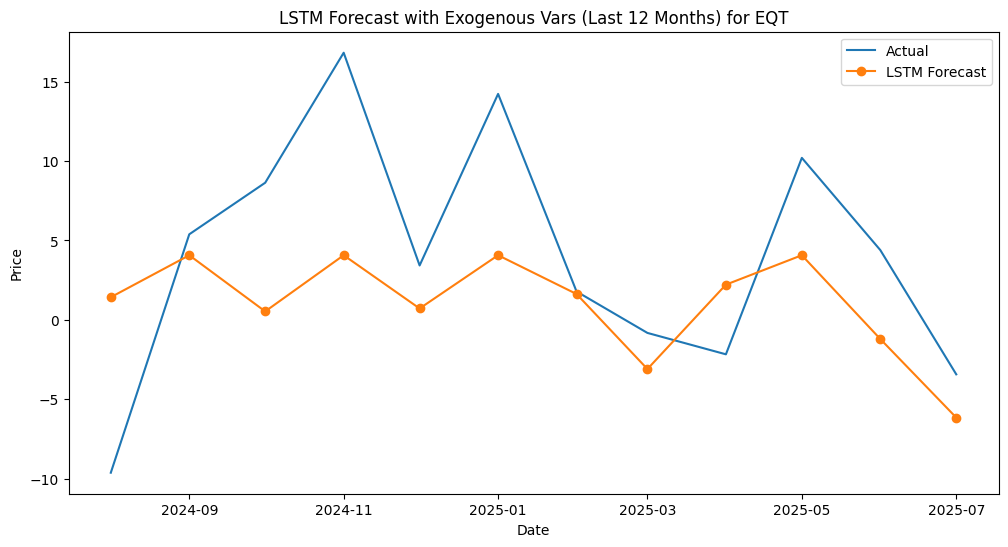

In [170]:
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, preds, label="LSTM Forecast", marker="o")
plt.title(f"LSTM Forecast with Exogenous Vars (Last {n_forecast} Months) for {target}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Adding in exogenous data, we see from the graph below that we were able to achieve similar model performance with or without the presence of this data. These models generally performed better with more parameters, more than likely because of the extra data, but weren't able to substantially improve model performance against our metrics. We do have some portions of the model that capture the trend of the data, like the EQT with exogenous data above and sections of the PNC forecast, but overall we obtain a model with similar errors.

The results are summarized below.

| RMSE / MAE | LSTM | LSTMEX |
|------------|------|--------|
|PNC | 5.7627 / 9.5701| 5.2856 / 9.7363|
|PPG | 4.2794 / 10.0447| 4.3353 / 9.1738|
|EQT | 6.6195 / 12.8124| 6.8866 / 12.7954|

## Project Summary

In this project, we tested a variety of statistical models for time series data. In particular we were curious of the effects of the addition of local economic variables on the stock percent changes for companies with a large corporate presence in Pittsburgh. Unsurprisingly, the effects of our exogenous variables on model performance varied by stock and model.

For the SARIMAX model family, we found that the PNC stock was relatively stable under seasonal patterns and with or without exogenous variables. Model predictions changed slightly, but there weren't any large changes in our evaluation metrics. Introduction of seasonal pattern in the PPG and EQT stock worsened performance across the board. More than likely these stocks do not exhibit any meaningful 12 month cycle and the addition of exogenous variables didn't improve our predictions much. It is important to note though, that our best performing models for both EQT and PPG were both the trivial models suggesting no direct linear relationship between exogenous variables and stock percentage change.

For our Tree model family, the random forest predictions and XGBoost predictions without exogenous variables were comparable to our best performing SARIMAX models. Introduction of exogenous variables slightly improved the stock predictions for PNC and PPG while worsening the EQT model performance. Tree models are able to approximate nonlinear relationships, which suggest that there may be a weak nonlinear relationship between our economic variables and PNC and PPG stock changes. Addition of these variables mostly reduced the max absolute error by around 10 percent. EQT seems more resistant to the effects of these variables. 

Our hybrid SARIMAX Tree model was competitive with our best SARIMAX models, but only slightly. Looking at the graphs generated, for PNC and PPG we had our trained residuals generally trending in the right direction, but the residual training worsened the EQT predictions.

Our LSTM models were our most accurate by a competive margin, although the LSTM prediction without exogenous variables for the PPG stock was mostly trivial. In this family, addition of exogenous variables had no direct model improvements even after hyperparemeter tuning for each model. This again suggests that any nonlinear relationship between our exogenous variables and our target stocks was undetectable by the model or isn't an explicit kind of relationship.


Overall, the data indicates that local economic variables like unemployment and median housing prices aren't significant predictors of local stock prices. 


